# Intro
## With description of dataset, how set up etc
Start with describing thought process etc

### Necessary import of packages and establishing connection with SQL-database

In [1]:
# Standard import packages/modules
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import datetime as dt

import pyodbc
import sqlalchemy

In [2]:
import urllib

params = 'DRIVER={ODBC Driver 17 for SQL Server};' \
         'SERVER=localhost,1401;' \
         'PORT=1433;' \
         'DATABASE=DDMVMS;' \
         'UID=sa;' \
         'PWD=YourStrong!Passw0rd;'
            
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine

db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

## Start with the first table
Looks like AnimalDaily is a good table to start with, let's import it into dataframe as df_ad

In [28]:
sql_ad = '''
SELECT *
FROM dbo.AnimalDaily;
'''

df_ad = pd.read_sql_query(sql_ad, db)
df_ad.head(5)

,OID,Date,BasicAnimal,AnimalGroup,DIM,DSLC,LactationNumber,TotalYield,IsYieldValid,Duration,AvgYieldPrev7d,GCRecord,SystemEntryTimeStamp
0,4,2016-12-29,221,3.0,310.0,310.0,1,22.670000,True,722.0,22.318571,None,NaT
1,25,2017-03-28,131,3.0,373.0,373.0,4,22.000000,True,797.0,19.425714,None,NaT
2,81,2017-01-23,237,3.0,144.0,144.0,1,16.910000,True,888.0,22.732857,None,NaT
3,93,2016-12-14,173,3.0,149.0,149.0,3,26.670000,True,919.0,34.272858,None,NaT
4,107,2017-02-09,232,3.0,219.0,219.0,1,20.459999,True,1619.0,22.738571,None,NaT


In [29]:
#Let's get some basic statistics to start with
df_ad.info()
df_ad.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33182 entries, 0 to 33181
Data columns (total 13 columns):
OID                     33182 non-null int64
Date                    33182 non-null object
BasicAnimal             33182 non-null int64
AnimalGroup             33148 non-null float64
DIM                     33180 non-null float64
DSLC                    33180 non-null float64
LactationNumber         33182 non-null int64
TotalYield              32683 non-null float64
IsYieldValid            33182 non-null bool
Duration                32683 non-null float64
AvgYieldPrev7d          32159 non-null float64
GCRecord                0 non-null object
SystemEntryTimeStamp    4975 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 3.1+ MB


,OID,BasicAnimal,AnimalGroup,DIM,DSLC,LactationNumber,TotalYield,Duration,AvgYieldPrev7d
count,33182.000000,33182.000000,33148.000000,33180.000000,33180.000000,33182.000000,32683.000000,32683.000000,32159.000000
mean,167693.555663,509.799409,3.100247,177.182278,177.185473,2.164577,29.561726,1069.272833,29.966063
std,63192.508714,728.093452,0.680902,118.119973,118.124011,1.349172,11.013999,470.079576,9.202937
min,4.000000,26.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.340000
25%,139916.750000,182.000000,3.000000,81.000000,81.000000,1.000000,21.930000,748.000000,22.885715
50%,188441.500000,224.000000,3.000000,167.000000,167.000000,2.000000,29.009998,1004.000000,29.534286
75%,214631.750000,245.000000,3.000000,257.000000,257.000000,3.000000,36.660000,1324.000000,35.997143
max,232894.000000,2277.000000,10.000000,1107.000000,1107.000000,7.000000,78.070000,4271.000000,60.987141


In [30]:
# We see that Date is stored as an object, convert to date(time)
df_ad['Date'] = pd.to_datetime(df_ad['Date'])

## Time-span: what time period are we talking about here?
Let's do a count per date and see how many cows have been milked by the robot over time, in order to get a sense of how good our data is and how large the herd is we're looking at.

In [31]:
# Check first and last date in dataset
print("First date: " + str(df_ad['Date'].min()))
print("Last date: " + str(df_ad['Date'].max()))
print("Number of rows in dataset: " + str(len(df_ad.index)))

First date: 2005-08-09 00:00:00
Last date: 2018-04-10 00:00:00
Number of rows in dataset: 33182


Seems like quite a long period of data we have in our database, over 33k records ranging from 2005 to 2018. <br>
Before moving on to checking out the number of cows and milk over time, let's inspect the quality of our data and see if we have any missing values.

## Let's check for missing values
It is important to see if we're missing values for for instance TotalYield and Duration, since these are some of the most important fields to visualize later on.


In [32]:
# check for missing values
df_ad.isnull().sum()

OID                         0
Date                        0
BasicAnimal                 0
AnimalGroup                34
DIM                         2
DSLC                        2
LactationNumber             0
TotalYield                499
IsYieldValid                0
Duration                  499
AvgYieldPrev7d           1023
GCRecord                33182
SystemEntryTimeStamp    28207
dtype: int64

__Note__ there are 34 missings for AnimalGroup, which should be fine. <br>
As we saw in the general descriptive statistics, most cows belong to group 3 so there is not much variation there. <br>
<br>
There are 499 missing rows however for TotalYield and Duration, which might be a bit more troublesome. <br>
Let's focus on these rows first and see if they are problematic or not. This allows to determine our course of action on what to do with them.

In [33]:
# Select the portion of dataframe with missing values for the column "TotalYield"
df_missing = df_ad[pd.isnull(df_ad["TotalYield"])]
df_missing.head(5)

,OID,Date,BasicAnimal,AnimalGroup,DIM,DSLC,LactationNumber,TotalYield,IsYieldValid,Duration,AvgYieldPrev7d,GCRecord,SystemEntryTimeStamp
75,1401,2016-01-18,112,4.0,280.0,280.0,4,NaN,True,NaN,NaN,None,NaT
83,1542,2012-10-08,178,3.0,0.0,0.0,0,NaN,True,NaN,NaN,None,NaT
117,2015,2014-12-04,204,9.0,0.0,0.0,0,NaN,True,NaN,NaN,None,NaT
118,2035,2014-12-26,208,9.0,0.0,0.0,0,NaN,True,NaN,NaN,None,NaT
122,2132,2016-07-27,211,3.0,324.0,324.0,1,NaN,True,NaN,NaN,None,NaT


It looks like that for some cows TotalYield is missing because DSLC _or days since last calf_ is 0.<br>
However, this does not hold true for all, shown by OID 1401 and 2132 for instance where LactationNumber is 4 and 1 respectively. <br>
<br>
What to do now? First, let's check out how many rows with missing TotalYield we have per value of LactationNumber (or number of calves a cow has had).<br>
<br>
It is good to know that a cow cannot start to produce milk without having given birth to at least one calf.

In [34]:
df_missing.groupby('LactationNumber').agg('count').OID

LactationNumber
0    305
1     79
2     46
3     29
4     22
5     13
6      4
7      1
Name: OID, dtype: int64

As it turns out we see that the majority of rows (305 out of 499) don't have a TotalYield because the cow didn't give birth to a calf yet. We'll filter out these rows from the dataset.
<br>
This leaves us with 194 rows which we'll filter out as well for the time being. 

In [35]:
del df_missing
df_ad = df_ad.dropna(subset = ['TotalYield'])

## Remove Duplicates
We can check for any duplicate values in the dataframe using function .duplicated() and remove them accordingly using function  drop_duplicates().

In [11]:
print("There are {} duplicated values.".format(df_ad.duplicated().sum()))
df_ad[df_ad.duplicated(keep=False)].head(10)

There are 0 duplicated values.


,OID,Date,BasicAnimal,AnimalGroup,DIM,DSLC,LactationNumber,TotalYield,IsYieldValid,Duration,AvgYieldPrev7d,GCRecord,SystemEntryTimeStamp


0 Duplicates, which is good. No need for further cleanup here.

## EDA

Let's start with checking out the amount of records over time

In [12]:
df_ad = df_ad.sort_values('Date')

Before plotting the count of records over time, let's increase default size of the plot

In [13]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

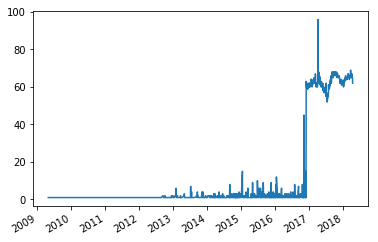

In [14]:
df_ad['Date'].value_counts().plot()

In [ ]:
#Use this code to pop up the plot and be able to inspect it more dynamically
%matplotlib tk
df_ad['Date'].value_counts().plot()

In [ ]:
# Run this code in order to toggle back on inline plotting of graphs
%matplotlib inline

As we can see there are not many datapoints in the beginning, it seems that things are taking of from 2017 onwards <br>
Also, the plot is a bit small, let's see if we can make subplots per year and/or month that are a bit more clear.

In [36]:
# Add Year and Yrmnth
df_ad['YearMonth'] = df_ad['Date'].map(lambda x: 100*x.year + x.month)

In [37]:
df_ad['Year'] = df_ad['Date'].dt.year
df_ad['Month'] = df_ad['Date'].dt.month

Check if we can plot trends for number of records, TotalYield and Duration per YearMonth, side by side

In [38]:
# Aggregate the df and check for # of records, # of unique cows, and sum of TotalYield and Duration
df_agg = df_ad.groupby(['YearMonth']).agg({'Year': max,
                                           'Month': max,
                                           'OID': "count", 
                                           'BasicAnimal': pd.Series.nunique, 
                                           'TotalYield': sum, 
                                           'Duration': sum})
df_agg = df_agg.reset_index()
df_agg.head(5)

,YearMonth,Year,Month,OID,BasicAnimal,TotalYield,Duration
0,200904,2009,4,1,1,0.000000,0.0
1,200908,2009,8,1,1,9.370001,470.0
2,200910,2009,10,2,2,17.460001,1268.0
3,200912,2009,12,1,1,44.780003,1517.0
4,201002,2010,2,2,2,74.830002,3009.0


In [39]:
# Add some extra columns, such as YieldPerCow and DurationPerTurn
# And then filter out all years before 2015
df_agg['YieldPerCow'] = df_agg['TotalYield'] / df_agg['BasicAnimal']
df_agg['DurationPerTurn'] = df_agg['Duration'] / df_agg['OID']
df_agg = df_agg[df_agg['Year']>=2015]

Now we have some decent summary stats that we can visualize <br>
Start with looking at the number of cows milked over the years

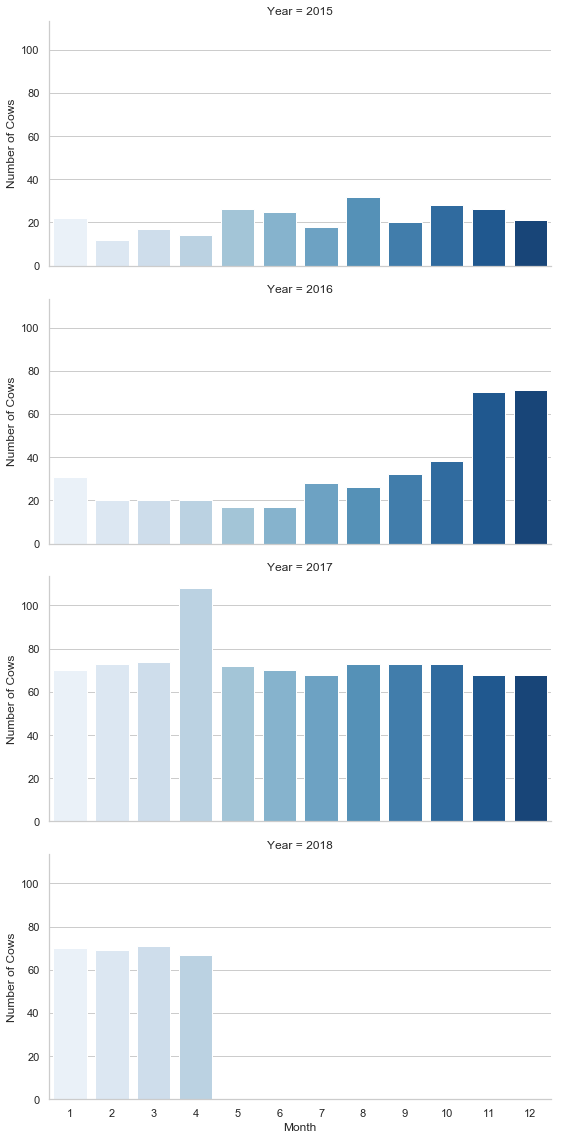

In [89]:
g = sns.catplot("Month","BasicAnimal", 
            data=df_agg, 
            kind="bar",
            row='Year',
            palette="Blues",
            height=4,
            aspect=2
           )

g.set_ylabels('Number of Cows')

# Nog aanpassen naar multiple subplots, 4 in een quadrant

In [ ]:
# Note, histogram van Gemiddelde yield per koe maken